In [20]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
from scipy.interpolate import interp1d as intp
import matplotlib.pyplot as plt
from astropy.io import fits
import source.selection_criteria as sc
import astropy.table as table
import astropy.units as u
import importlib
from sklearn.neighbors import KernelDensity

utils.configure_plot_params()

/Users/runburg/github/agn_lf


In [21]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
outfile = 'lf_xray'
label = 'Full XSERVS sample'
specz = 'ZSPEC'
photoz = 'ZPHOT'
band = 'FB_FLUX'
truncate_radec=[34.2, 37.1, -5.73, -3.87]

specz_only = True
if specz_only is True:
    outfile = 'lf_xray_specz_only'
    label = 'Only specz'

xmatch = False
ir_select = False
gaussian_uncertainty = False


if xmatch is True:
    fullsamplecat = xservs_catalog
    xservs_catalog = table.Table.read('./data/xmatch_catalog_1_arcsec.fits')
#     xservs_catalog = table.Table.read('./data/ir_and_xray.fits')
    outfile = 'lf_xray_crossmatch_xray_selected'
    specz = 'zspec_1'
    # specz = 'redshift'
    # photoz = 'ZPHOT'
    photoz = 'redshift'
    label = 'Crossmatch, X-ray selected'
    if ir_select is True:
        outfile = 'lf_xray_crossmatch_ir_selected'
        label = 'Crossmatch, IR selected'

    ra_up = 36.5
    ra_down = 34.25
    dec_up = -4.0
    dec_down = -5.5 
    catalog = xservs_catalog
    xservs_catalog = xservs_catalog[(ra_down < catalog['RA_2']) & (catalog['RA_2'] < ra_up)& (dec_down < catalog['DEC_2']) & (catalog['DEC_2'] < dec_up)]
    fullsamplecat = fullsamplecat[(ra_down < fullsamplecat['RA']) & (fullsamplecat['RA'] < ra_up)& (dec_down < fullsamplecat['DEC']) & (fullsamplecat['DEC'] < dec_up)]
    truncate_radec = [ra_down, ra_up, dec_down, dec_up]

    if ir_select is True:
        flux36 = 'f_ap_irac_i1'
        flux45 = 'f_ap_irac_i2'
        flux58 = 'f_ap_irac_i3'
        flux80 = 'f_ap_irac_i4'
        flux240 = 'f_mips_24'
        never_nan = (np.nan_to_num(xservs_catalog[flux58], nan=-99) > 0) & (np.nan_to_num(xservs_catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(xservs_catalog[specs], nan=-99) > 0)

        selected_agn = sc.select_ir(xservs_catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
        xservs_catalog = xservs_catalog[never_nan][selected_agn]
        
if gaussian_uncertainty is True:
    outfile += '_gaussian_uncertainty'
       
x_selected = [('2' in set(str(clas))) for clas in xservs_catalog['CLASS'].data]
if specz_only is True:
    full_fluxes = xservs_catalog[(xservs_catalog[photoz] > 0 ) | (xservs_catalog[specz] > 0)]
    xservs_catalog = xservs_catalog[(np.nan_to_num(xservs_catalog[specz], nan=-99) > 0) & x_selected]
elif xmatch is True:
    xservs_catalog = xservs_catalog[(xservs_catalog[photoz] > 0 ) | (xservs_catalog[specz] > 0)]
    full_fluxes = fullsamplecat
else:
    xservs_catalog = xservs_catalog[((xservs_catalog[photoz] > 0 ) | (xservs_catalog[specz] > 0)) & x_selected]
    full_fluxes = xservs_catalog

In [22]:
# catalog = table.Table.read('./data/tableA.v01.fits')
# difit = ((catalog['CLASS'].data // 10**1) % 10)
# print(catalog['CLASS'].data[50:150])
# print(difit[50:150])
# np.sum(difit==2)

In [23]:
# xservs_catalog.colnames


In [24]:
# xservs_catalog['CSCID']

In [25]:
selection_lum = 3e42

# xservs_catalog = 

cosmo = af.setup_cosmology()

print(len(xservs_catalog))

1723


In [26]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 2e43 #erg/s
l_sample_max = 3e46 #erg/s 

num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

flux_limit = 6.5e-15

image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
wcs, hdu = utils.load_wcs(image_file)

cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9, truncate_radec=truncate_radec)

# full_fluxes = xservs_catalog['FB_FLUX']
goodzs = (xservs_catalog[photoz] > 0) & (xservs_catalog[specz] > 0)

ratio = xservs_catalog['FB_FLUX'] /  xservs_catalog['HB_FLUX'] 
goodobjs = (ratio < ratio.mean() + 3*ratio.std()) & (ratio > ratio.mean() - 3*ratio.std())

kds = []
for i in np.arange(len(z_bins)-1):
    inbin = (xservs_catalog[photoz][goodzs] > z_bins[i]) & (xservs_catalog[photoz][goodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xservs_catalog[specz][goodzs][inbin][:, None])
    
    kds.append(kde)
    
# spectral_index = 1.7
spectral_index = np.log10(xservs_catalog['HB_FLUX'].data/xservs_catalog['SB_FLUX'].data) / np.log10(6/1.25)
print(spectral_index.mean(), spectral_index.std())
bolo_corr = 1
# bolo_corr = 12

with np.load('./data/incompleteness_corrections_mag.npz') as f:
    mags = f['mags']
    corrs = f['corrs']
    f_corr = f['fluxes']

corr_fn = intp(f_corr, corrs, bounds_error=False, fill_value=1) 

N = 10000

if specz_only is True:
    N = 1


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


/Users/runburg/github/agn_lf/source/vmax.py:223: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(data[:-1, :-1] * truncate_radec).flatten()


The total coverage is 5.392516341375583 square degrees.
0.8464822596820915 0.49080907751397934


In [27]:
xservs_catalog[photoz].sum()

-106101.375

In [28]:
# fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='X', unit=r'erg s$^{-1}$')
band_correction = (xservs_catalog['FB_FLUX'] / xservs_catalog['HB_FLUX']).mean()

print("Band correction is", band_correction)
# Band correction is 1.0416882076168126
band_correction = 1.0416882076168126

Band correction is 1.2090106329374477


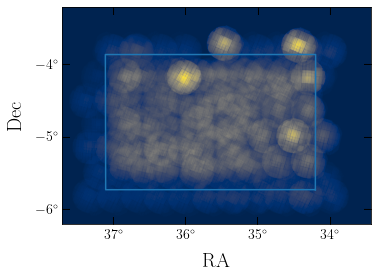

In [10]:
if xmatch is False:
    vmax.exposure_plot(wcs, hdu.data, outfile='./output/paper_plots/exposure_map.pdf', truncate_radec=truncate_radec)

Total coverage for: 5.38599400128031 square degrees.


(<Figure size 388.8x280.8 with 1 Axes>,
 <AxesSubplot:xlabel='$0.2$-$10$ keV flux [erg cm$^{-2}$ s$^{-1}$]', ylabel='Coverage [deg$^2$]'>)

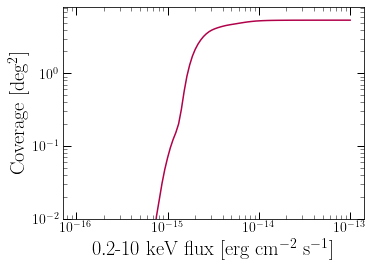

In [11]:
vmax.cov_func_plot(cov_function, -16, -13, outfile='./output/paper_plots/xservs_coverage.pdf')

In [12]:
import time
start_time = time.time()
lf_chain = np.zeros((N, num_bins_z-1, num_bins_l-1))
# lf_err_chain = lf_chain[:]

for i in range(N):
    if i % 50 == 0:
        print('progress', round(i/N * 100, 2), '%')
        

    randomz = np.zeros(len(xservs_catalog))
    xservs_catalog['random_z'] = randomz
    ### use zphot - ZSPEC to estimate uncertainty on z
#     for j in np.arange(len(z_bins) - 1):
#         inbin = (xservs_catalog[photoz][goodzs] >= z_bins[j]) & (xservs_catalog[photoz][goodzs] < z_bins[j+1])
#         histo, bin_edges = np.histogram(difs[inbin], bins=200)

#         photoz_inbin = (xservs_catalog[photoz] >= z_bins[j]) & (xservs_catalog[photoz] < z_bins[j+1])
#         randomz[photoz_inbin] = xservs_catalog[photoz][photoz_inbin] - np.random.choice((bin_edges[:-1]), size=np.sum(photoz_inbin), p=histo/np.sum(histo))
        
#         while np.any(randomz < 0):
#             indices = randomz < 0
#             randomz[indices] = xservs_catalog[photoz][indices] - np.random.choice((bin_edges[:-1]), size=np.sum(indices), p=histo/np.sum(histo))
    if gaussian_uncertainty is False:
        for j, kd in enumerate(kds):
            photoz_inbin = (xservs_catalog[photoz] >= z_bins[j]) & (xservs_catalog[photoz] < z_bins[j+1])
            randomz[photoz_inbin] = kd.sample(np.sum(photoz_inbin)).flatten()

        xservs_catalog['random_z'] = randomz
    else:
        nonzerophotoz = (xservs_catalog[photoz] >= 0)
        means = xservs_catalog[photoz][nonzerophotoz]
        sigmas = 0.2 * (1 + means)
        xservs_catalog[nonzerophotoz]['random_z'] = np.random.normal(means, sigmas)
        
    z = np.array([row[specz] if row[specz] > 0 else row['random_z'] for row in xservs_catalog])  
#     z = np.array([row[specz] if row[specz] > 0 else np.random.normal(row[photoz], (row['ZPHOT_UERR'] - row['ZPHOT_LERR'])/2) for row in xservs_catalog])

    l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value.astype(np.float64)**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index) * bolo_corr

    good_redshift_and_l_selected = ((l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z) & (l > selection_lum)).astype(bool) & goodobjs
    l = l[good_redshift_and_l_selected]
    z = z[good_redshift_and_l_selected]
#     print(time.time() - start_time)
    if i == 0:
        print('number of selected agn', np.sum(good_redshift_and_l_selected))
    coverage_correction = vmax.coverage_correction(full_fluxes['FB_FLUX'], xservs_catalog[good_redshift_and_l_selected]['FB_FLUX'])
#     print(time.time() - start_time
    
    zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False, output=False)
    zmin = np.array([0]*len(zmax))
#     print(time.time() - start_time)

    def corrected_cov_func(l, z):
        flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value.astype(np.float64)**2)
        
        return coverage_correction(flux) * cov_function(flux) #* corr_fn(flux)
#         return cov_function(flux) #* corr_fn(flux)

    vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=corrected_cov_func)
#     print(time.time() - start_time)
    
    lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins, poisson_error=False)
#     print(time.time() - start_time)
    
    lf_chain[i] = lf_vals
#     lf_err_chain[i] = lf_errs
    
print(time.time() - start_time)


progress 0.0 %
number of selected agn 1244
0.2147998809814453


/Users/runburg/github/agn_lf/source/vmax.py:203: RuntimeWarning: invalid value encountered in true_divide
  corrections = selected_binned / full_binned
/Users/runburg/github/agn_lf/source/vmax.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(lf), np.array(errors)


(1, 9, 14)


(0.0, 0.0, 0)

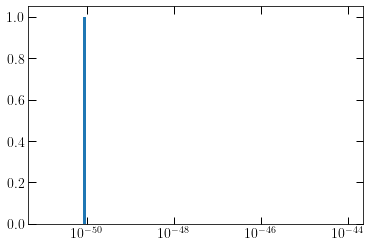

In [13]:
lf_mean = np.mean(lf_chain, axis=0)
lf_mean_err = np.std(lf_chain, axis=0)
# print(lf_mean_err*np.log(10)*(l_bins[1:]-l_bins[:-1])/2)
print(lf_chain.shape)
plt.hist(lf_chain[:, 2, 5], bins=np.logspace(-51, -44, num=100))
ax = plt.gca()
ax.set_xscale('log')
bin_centers = (l_bins[1:]+l_bins[:-1])/2
min(lf_chain[:, 5, -1]), lf_mean[5, -1]*bin_centers[-1]*np.log(10), np.sum(np.isnan(lf_chain))


In [14]:
sorted_lf = np.sort(lf_chain, axis=0)
# probs = np.cumsum(sorted_lf, axis=0)
# probs /= probs[-1]
# probs = np.nan_to_num(probs)
# print(probs)
mid_id = len(sorted_lf) // 2
high_id = (len(sorted_lf) * 84) // 100
low_id = (len(sorted_lf) * 16) // 100
print(low_id, mid_id, high_id, len(sorted_lf))

# print(lf_errs.shape, sorted_lf.shape)
sh = sorted_lf.shape
median_vals = np.zeros((sh[1], sh[2]))
med_errs = np.zeros((sh[1], 2, sh[2]))
# low_errs = np.zeros((sh[1], sh[2]))
for i in range(sh[1]):
    for j in range(sh[2]):
        bin_results = sorted_lf[:, i, j][sorted_lf[:, i, j] > 0]
        if len(bin_results) < 1:
            median_vals[i, j] = 0
            med_errs[i, :, j] = [0, 0]
            continue
        mid_id = len(bin_results) // 2
        high_id = (len(bin_results) * 84) // 100
        low_id = (len(bin_results) * 16) // 100
        
#         median_vals[i, j] = sorted_lf[:, i, j][mid_id]
        median_vals[i, j] = bin_results[mid_id]
        # compeltely rework this!!!!!
        med_errs[i, 1, j] = bin_results[high_id] - median_vals[i, j]
#         med_errs[i, 1, j] = sorted_lf[:, i, j][high_id]
        med_errs[i, 0, j] = median_vals[i, j] - bin_results[low_id]
#         med_errs[i, 0, j] = sorted_lf[:, i, j][low_id]

# print(med_errs.shape, np.moveaxis(lf_errs, 1, -1).shape)
print(np.sum(np.isnan(med_errs)), 'nans')
# med_errs
# med_errs = np.sqrt(med_errs**2 + np.moveaxis(lf_errs, 1, -1)**2)
# print(lf_errs)
print(med_errs[:, 0, :] )


0 0 0 1
0 nans
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
z = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in xservs_catalog])
l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value.astype(np.float64)**2 * xservs_catalog['FB_FLUX'] * (1 + z)**(-1 + spectral_index)

poi_lower, poi_upper = vmax.poisson_errors(l, z, l_bins, z_bins)
print(median_vals[-3, -5])
print(poi_upper[-3, -5])
print(med_errs[-3, 1, -5])
for i in range(sh[1]):
    for j in range(sh[2]):
        med_errs[i, 1, j] = np.sqrt(med_errs[i, 1, j]**2 + (median_vals[i, j] * poi_upper[i, j])**2)
        med_errs[i, 0, j] = np.sqrt(med_errs[i, 0, j]**2 + (median_vals[i, j] * poi_lower[i, j])**2)
        if np.any(poi_upper[i, j] == 0):
            median_vals[i, j] = 0
        
print(med_errs.max())
print(med_errs[-3, 1, -5])


print(median_vals[-1])
print(med_errs[-1])
print(poi_upper[-1])

0.0
0.0
0.0
3.4272763779890093e-47
0.0
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.46125215e-51 1.03534515e-50 2.76379900e-51
 4.03031783e-52 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.86245553e-51 3.58229423e-51 7.56643127e-52
  1.48603576e-52 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.96087995e-51 5.11201669e-51 9.99219640e-52
  2.17061403e-52 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
lit_data={}
others_limits = {}
x_ray_correction = {}
aird_lade_params_central = {'A': 10**-4.53, 
                               'gamma1':0.62, 
                               'gamma2':3.01,
                               'Lstar': 10**44.77,
                               'zc':0.75,
                               'p1':6.36,
                               'p2':-0.24,
                               'd':-0.19
                              }
aird_lade_params_min = {'A': 10**-4.46, 
                               'gamma1':0.6, 
                               'gamma2':2.9,
                               'Lstar': 10**44.71,
                               'zc':0.66,
                               'p1':5.96,
                               'p2':-0.51,
                               'd':-.21
                              }
aird_lade_params_max = {'A': 10**-4.6, 
                               'gamma1':0.64, 
                               'gamma2':3.12,
                               'Lstar':10**44.83,
                               'zc':0.84,
                               'p1':6.76,
                               'p2':0.03,
                               'd':-0.17
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(40, 47.0, num=50)
aird_mid = af.LADE(ls, center_zbins, **aird_lade_params_central, no_k=True)
aird_high = af.LADE(ls, center_zbins, **aird_lade_params_max, no_k=True)
aird_low = af.LADE(ls, center_zbins, **aird_lade_params_min, no_k=True)
aird_limits = [[41, 45.25], [41, 45.25], [41.75, 45.75], [41.75, 45.75], [46, 46], [46, 46], [42.5, 45], [42.5, 45.25], [42.5, 45.25]]
others_limits['Aird LADE'] = 10**np.array(aird_limits)
for other_dat in (aird_high, aird_low, aird_mid):
    for dat in other_dat:
        dat[:, 0] *= band_correction

aird_limits = band_correction * np.array(aird_limits)
# print(ranalli_mid[0])
lit_data['Aird LADE'] = list(zip(aird_mid, aird_high, aird_low))
x_ray_correction['Aird LADE'] = band_correction
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

In [30]:
importlib.reload(utils)
importlib.reload(vmax)
ranalli_lade_params_central = {'A': 10**-3.53, 
                               'gamma1':0.16, 
                               'gamma2':2.48,
                               'Lstar': 10**42.72,
                               'zc':1.72,
                               'p1':4.67,
                               'p2':-0.3,
                               'd':-0.29
                              }
ranalli_lade_params_min = {'A': 10**-3.65, 
                               'gamma1':0.09, 
                               'gamma2':2.37,
                               'Lstar': 10**42.65,
                               'zc':1.53,
                               'p1':4.35,
                               'p2':-0.91,
                               'd':-0.31
                              }
ranalli_lade_params_max = {'A': 10**-3.48, 
                               'gamma1':0.23, 
                               'gamma2':2.6,
                               'Lstar':10**42.82,
                               'zc':1.93,
                               'p1':5.0,
                               'p2':0.02,
                               'd':-0.26
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(40, 47.0, num=50)
ranalli_mid = af.LADE(ls, center_zbins, **ranalli_lade_params_central)
ranalli_high = af.LADE(ls, center_zbins, **ranalli_lade_params_max)
ranalli_low = af.LADE(ls, center_zbins, **ranalli_lade_params_min)

ranalli_limits = [[42, 45], [42, 46], [42, 46], [42.25, 46], [42.25, 46], [42.5, 45.25], [43.25, 45.25], [43.25, 45.25], [43.25, 45.25]]
others_limits['Ranalli LADE'] = 10**np.array(ranalli_limits)
# print(ranalli_mid[0])
lit_data['Ranalli LADE'] = list(zip(ranalli_mid, ranalli_high, ranalli_low))
x_ray_correction['Ranalli LADE'] = 1
# np.array(lit_data['Ranalli LADE'])[0], np.array(lit_data['Aird 2010'])[0]

In [31]:
# # plot_files = ['./output/lf_ir_montecarlo.npz']
# plot_files = ['./output/lf_xray.npz', './output/lf_xray_crossmatch_ir_selected.npz', './output/lf_xray_crossmatch_xray_selected.npz']
# # plot_files = []
# labs = ['Full XSERVS sample', 'Crossmatch, IR selected', 'Crossmatch, X-ray selected']
# otherruns = {}
# for lab, fil in zip(labs, plot_files):
#     with np.load(fil) as infile:
#         lfv = infile['lf_vals']
#         lfe = infile['lf_errs']
#     otherruns[lab] = [lfv, lfe]

In [32]:
import importlib
importlib.reload(vmax)

# otherruns = {}
np.savez('./output/' + outfile + '.npz', lf_vals=median_vals, lf_errs=med_errs, z_bins=z_bins, l_bins=l_bins)

NameError: name 'median_vals' is not defined

In [33]:
l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()

plot_files = ['./output/lf_xray.npz', './output/lf_xray_crossmatch_ir_selected.npz']#, './output/lf_xray_gaussian_uncertainty.npz']

labs = ['Full XSERVS sample', 'Comparative, IR selected', 'Gaussian uncertainty']#, 'Crossmatch, X-ray selected']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]
    

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

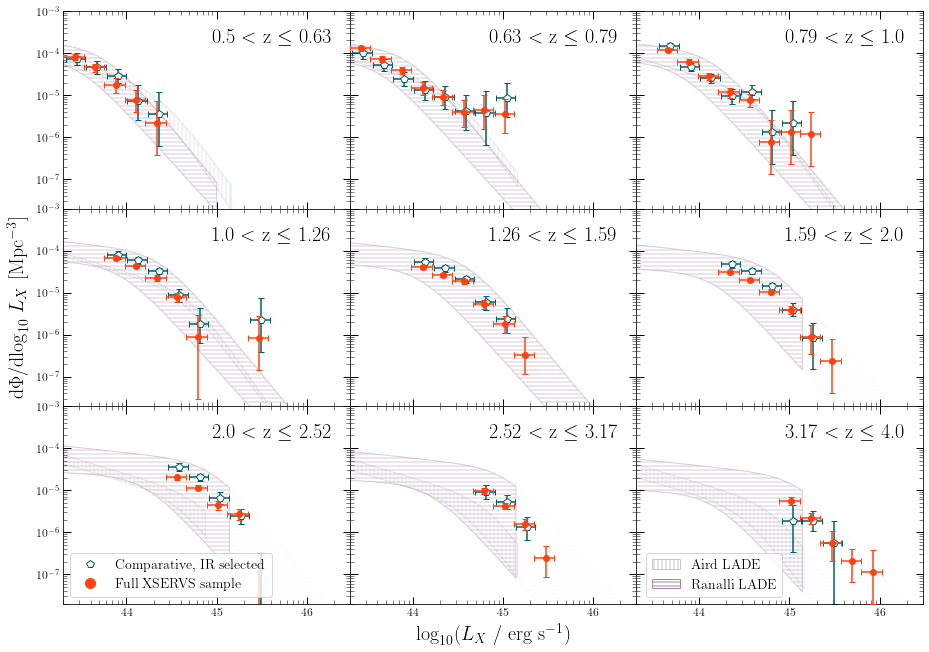

In [19]:
import importlib
importlib.reload(vmax)

main_results = otherruns.pop(labs[0])

outfile = 'lf_xray_xmatch'

fig, axs, big_ax = vmax.plot_lf_vmax(main_results[0], main_results[1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, others_limits=others_limits, lum_limits=l_limits, this_label=labs[0], title=None, outfile='./output/paper_plots/'+outfile+'.pdf', lum_sublabel='_X')

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

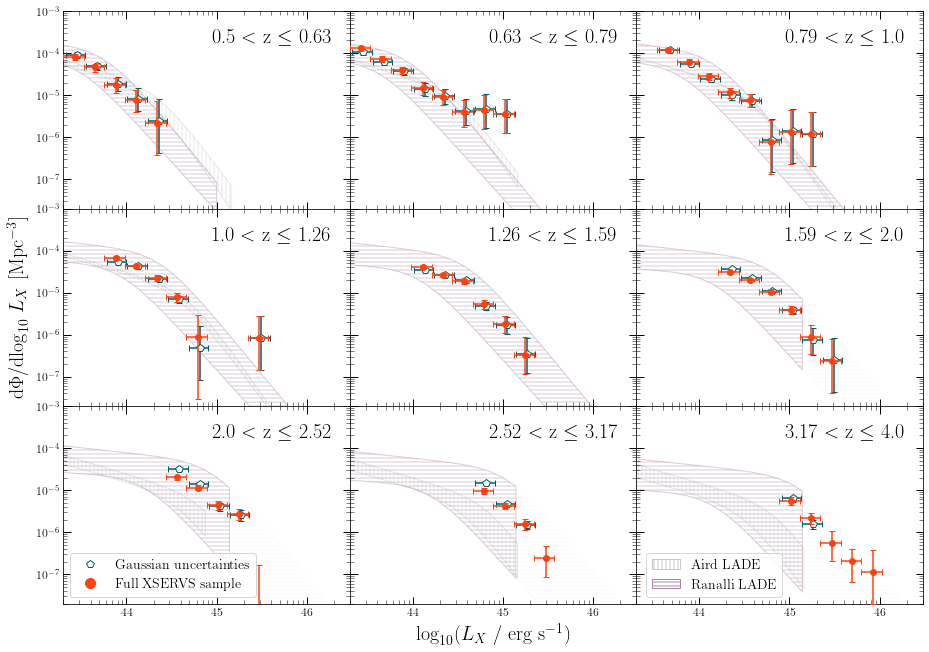

In [15]:
import importlib
importlib.reload(vmax)

# otherruns = {}

plot_files = ['./output/lf_xray.npz', './output/lf_xray_gaussian_uncertainty.npz']

labs = ['Full XSERVS sample', 'Gaussian uncertainties']#, 'Crossmatch, X-ray selected']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]


import importlib
importlib.reload(vmax)

main_results = otherruns.pop(labs[0])

outfile = 'lf_xray_gaussian_uncertainties'

fig, axs, big_ax = vmax.plot_lf_vmax(main_results[0], main_results[1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, others_limits=others_limits, lum_limits=l_limits, this_label=labs[0], title=None, outfile='./output/paper_plots/'+outfile+'.pdf', lum_sublabel='_X')

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

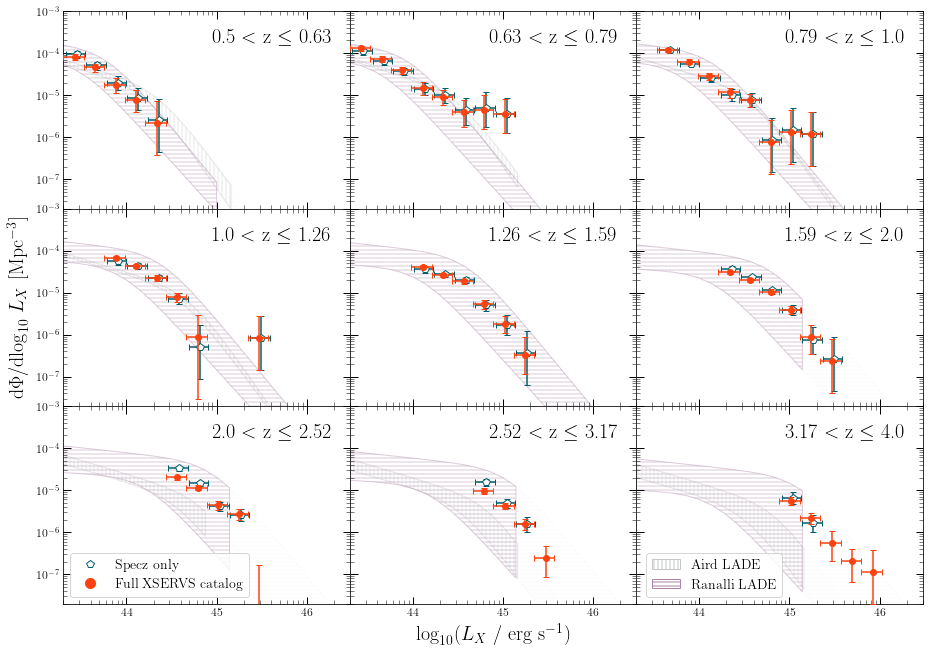

In [16]:
plot_files = ['./output/lf_xray.npz']
labels = ['full XSERVS catalog']
mainruns = {}
for lab, fil in zip(labels, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    mainruns[lab] = [lfv, lfe]
    
plot_files = ['./output/lf_xray_specz_only.npz']
labs = ['Specz only']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]

outfile = 'lf_xray_full_vs_specz'
label = 'Full XSERVS catalog'
fig, axs, big_ax = vmax.plot_lf_vmax(mainruns[labels[0]][0], mainruns[labels[0]][1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, lum_limits=l_limits, title=None, others_limits=others_limits, this_label=label, outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{X}')

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

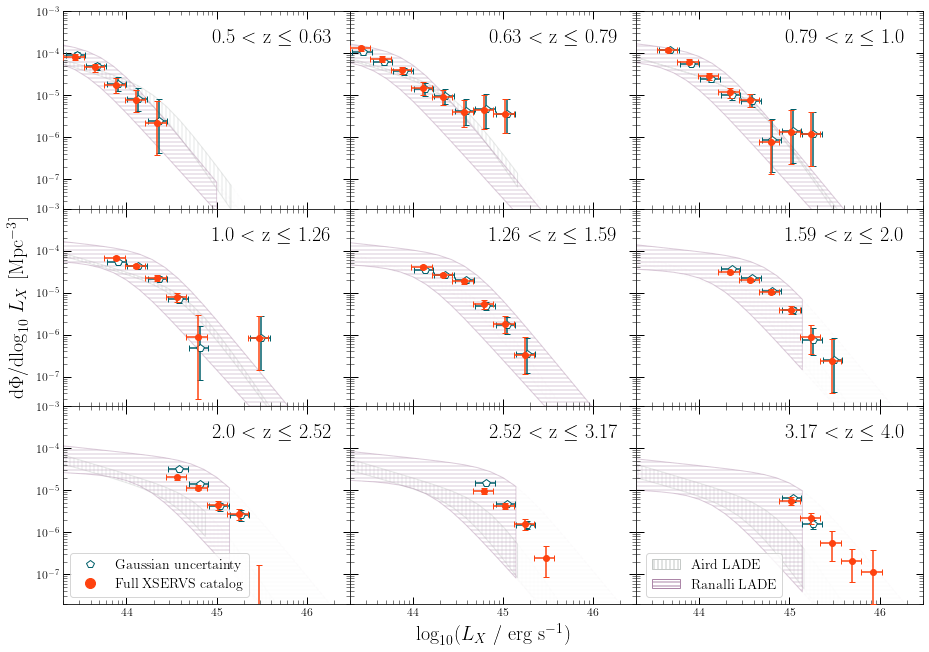

In [17]:
plot_files = ['./output/lf_xray.npz']
labels = ['full XSERVS catalog']
mainruns = {}
for lab, fil in zip(labels, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    mainruns[lab] = [lfv, lfe]
    
plot_files = ['./output/lf_xray_gaussian_uncertainty.npz']
labs = ['Gaussian uncertainty']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]

outfile = 'lf_xray_gaussian_uncertainty'
label = 'Full XSERVS catalog'
fig, axs, big_ax = vmax.plot_lf_vmax(mainruns[labels[0]][0], mainruns[labels[0]][1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, lum_limits=l_limits, title=None, others_limits=others_limits, this_label=label, outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{X}')

[-4.2  0.4  2.5 43.8]
[-4.3  0.4  2.5 43.9]
[-4.4  0.4  2.5 44.2]
[-4.5  0.4  2.5 44.3]
[-4.6  0.4  2.5 44.5]
[-4.6  0.4  2.5 44.6]
[-4.7  0.4  2.5 44.7]
[-4.9  0.5  2.5 44.8]
[-5.   0.5  2.5 44.9]


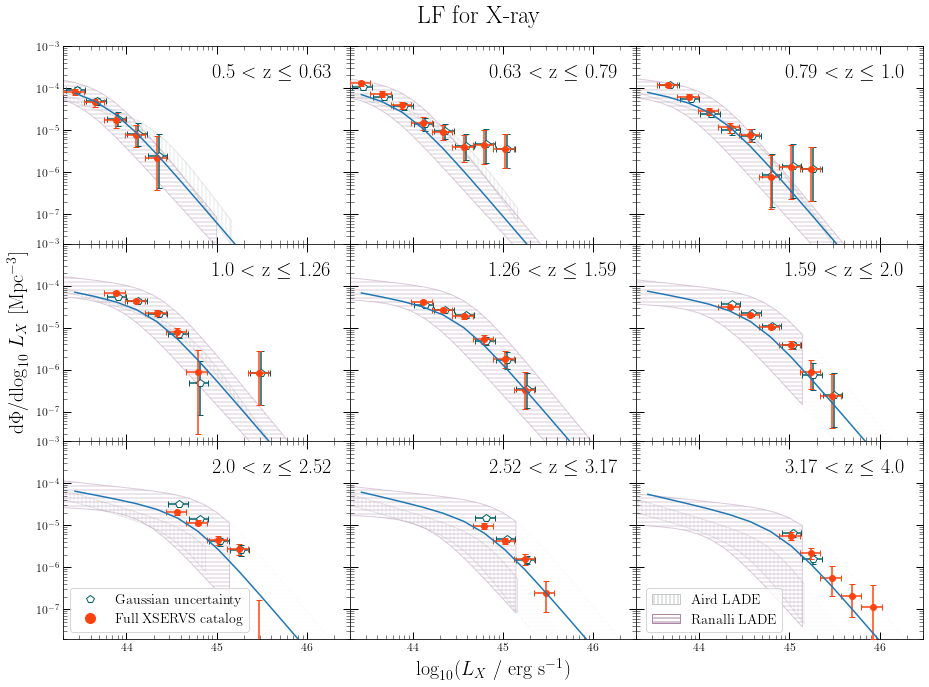

In [24]:
from scipy import odr
def double_power_law(params, L):
    A, gamma1, gamma2, Lstar = params.astype(complex)
#     if (A > -3.8) or (A < -5.0):
#     if (A < -5.0):
#         return 1e200
#     if (gamma2 < 2) or (gamma2 > 7):
#         return 1e200
#     if (Lstar > 46.5):
#         return 1e200
    return (10**A / ((L / 10**Lstar)**gamma1 + (L / 10**Lstar)**gamma2)).real

lum_errors = (l_bins[1:] - l_bins[:-1]) / 2
bin_centers = (l_bins[:-1] + l_bins[1:]) / 2

amps = np.array([-4.2, -4.3, -4.4, -4.5, -4.6, -4.6, -4.7, -4.9, -5.0])
gamma1s = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5])
gamma2s = np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Lstars = np.array([43.8, 43.9, 44.2, 44.3, 44.5, 44.6, 44.7, 44.8, 44.9])
param_list=np.array([amps, gamma1s, gamma2s, Lstars]).T
lstarini = np.log10(3e45)
i=0
for lf, lferr, ax in zip(mainruns[labels[0]][0], mainruns[labels[0]][1], axs):
    dpl = odr.Model(double_power_law)
    lferr[lferr == 0.0] = np.nan
    fixed = np.zeros(len(lf))
    fixed[lf == 0] = 1
#     mydata = odr.RealData(bin_centers, lf * bin_centers * np.log(10), sx=lum_errors, sy=1)
#     print(lf, lferr[1])
#     mydata = odr.RealData(bin_centers, lf * bin_centers * np.log(10))
    mydata = odr.RealData(bin_centers, lf * bin_centers * np.log(10), sx=lum_errors, sy=lferr[0] * np.log(10) * bin_centers * 1.00)
    myodr = odr.ODR(mydata, dpl, beta0=param_list[i], ifixb=[1, 1, 1, 1], maxit=400, stpb=[0.1, 0.01, 0.01, 1])
    i+=1
    myoutput = myodr.run()
    
#     lstarini += 0.1
    print(myoutput.beta)
#     if myoutput.beta[0] < -5: myoutput.beta[0] = -5
    ax.plot(bin_centers, double_power_law(myoutput.beta, bin_centers), zorder=500)
        
        
fig

In [25]:
mainruns[labels[0]][0][-3] * bin_centers * np.log(10), mainruns[labels[0]][1][-3] * bin_centers * np.log(10)

(array([0.00000000e+00, 0.00000000e+00, 1.93180426e-06, 7.57116569e-06,
        1.38135387e-04, 2.00248906e-05, 1.14955966e-05, 4.52492961e-06,
        2.63989877e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([[           nan, 3.45080798e-05, 1.66740157e-06, 2.14638727e-06,
         2.99018401e-05, 2.24981575e-06, 1.56641357e-06, 1.06058974e-06,
         7.37259840e-07, 2.03112770e-09,            nan,            nan,
                    nan,            nan],
        [           nan, 1.36084971e-05, 4.87574957e-06, 2.22768413e-06,
         7.40311612e-05, 2.30622462e-06, 1.59192077e-06, 1.09837430e-06,
         9.27433239e-07, 1.65373923e-07, 1.51400055e-09,            nan,
                    nan,            nan]]))

In [26]:
np.sum((l > l_bins[5]) & (z > z_bins[1]) & (z < z_bins[2])), z_bins[1], z_bins[2], l_bins[5]

(7, 0.6299605249474366, 0.7937005259840997, 2.7248857796902753e+44)

In [27]:
# l = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=20)
# z = np.linspace(z_sample_min, z_sample_max, num=20)
# corrected_cov_func(l, z)


In [28]:
np.sum((z > z_bins[1]) & (z < z_bins[2])), z_bins[1], z_bins[2], l_bins[5]

(206, 0.6299605249474366, 0.7937005259840997, 2.7248857796902753e+44)

6 6.5e-15
ZPHOT       ZSPEC               HB_FLUX                FB_FLUX        
----- ------------------ ---------------------- ----------------------
-99.0          0.7884797 1.0542987037651537e-13 1.7151797605646254e-13
-99.0 0.6330000162124634 1.7074410411451583e-13  3.741436961608253e-13
-99.0 0.7143866999999999  2.740500201938027e-13  5.124923647381097e-13
-99.0          0.6922893  1.498547371755258e-13  2.437296336204253e-13
-99.0          0.7606254  3.478902104777951e-13  6.296163927044782e-13
-99.0          0.6952522 4.9262184931678266e-14  1.151484926696098e-13


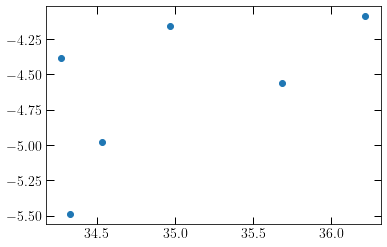

In [29]:
subsample = xservs_catalog[(l > 3e44) & (z > 0.63) & (z < 0.79)]
# subsample = catalog[(x_l > 2e45) & (x_z > 2) & (x_z < 2.52)]
print(len(subsample), flux_limit)
plt.scatter(subsample['RA'], subsample['DEC'])
print(subsample['ZPHOT', 'ZSPEC', 'HB_FLUX', 'FB_FLUX'])

In [30]:
subsample['CSCID', 'XID']

CSCID,XID
bytes29,bytes8
-99,XMM00133
-99,XMM00226
-99,XMM00653
-99,XMM01439
-99,XMM02749
acisfJ0224067m041228_001.0110,XMM03739


In [31]:
subsample.colnames[110:115]


['CSCID', 'XXLID', 'NALL_SERVS', 'NALL_VIDEO', 'NALL_CFHT']

In [32]:
sub = table.Table.read('./weird_xray_objects.fits')

In [42]:
sub.colnames
print('XID\t\tOIR_RA\t\t\tOIR_DEC')
for x, ra, dec in sub['XID', 'OIR_RA', 'OIR_DEC']:
    print(f'{x}\t{ra}\t{dec}')


XID		OIR_RA			OIR_DEC
XMM00133	34.27293419230594	-4.3815758386269215
XMM00226	34.32724029230594	-5.489066388626921
XMM00653	34.53430529230594	-4.979275688626921
XMM00724	34.57261079230594	-4.853499188626921
XMM01439	34.96734929230594	-4.155511588626921
XMM02749	35.684959992305934	-4.563076338626922
XMM03739	36.21746814230594	-4.0887412386269215
XMM05158	37.03789134230594	-4.209654188626922
XMM05226	37.10826284230593	-4.732458088626921
